In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [ ]:
# Importing modules

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from zipfile import ZipFile

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [ ]:
# Loading zip image files - for extracting images

class LoadDataModule(object):
    def __init__(self):
        self.DIR = '/content/drive/MyDrive/datasets/DL_images/'
    
    # Returns images and labels corresponding for training and testing. Default mode is train. 
    # For retrieving test data pass mode as 'test' in function call.
    def load(self, mode = 'train'):
        label_filename = mode + '_labels'
        image_filename = mode + '_images'
        label_zip = self.DIR + label_filename + '.zip'
        image_zip = self.DIR + image_filename + '.zip'
        with ZipFile(label_zip, 'r') as lblzip:
            labels = np.frombuffer(lblzip.read(label_filename), dtype=np.uint8, offset=8)
        with ZipFile(image_zip, 'r') as imgzip:
            images = np.frombuffer(imgzip.read(image_filename), dtype=np.uint8, offset=16).reshape(len(labels), 784)
        return images, labels

In [ ]:
# Defining image dataset

class ImagesDataset(Dataset):
    def __init__(self, images, labels, transform=None, label_transform=None):
        self.images = images
        self.labels = labels.astype("long")
        self.transform = transform
        self.label_transform = label_transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx, :]
        label = self.labels[idx]
        image = np.reshape(image, (28,28))
        if self.transform != None:
            image = self.transform(image)
        if self.label_transform != None:
            label = self.label_transform(label)
        return image, label

In [ ]:
# Getting datasets

data_module = LoadDataModule()

train_data, train_labels = data_module.load("train")        # 60,000 images - (28,28) flattened to 784 - value (0, 255)
X_test, y_test = data_module.load("test")                   # 10,000 images - (28,28) flattened to 784 - value (0, 255)


X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2)


training_data = ImagesDataset(X_train, y_train, transform=ToTensor())         # 48,000 images - (28,28) flattened to 784 - value (0, 255)
validation_data = ImagesDataset(X_val, y_val, transform=ToTensor())           # 12,000 images - (28,28) flattened to 784 - value (0, 255)
testing_data = ImagesDataset(X_test, y_test, transform=ToTensor())            # 10,000 images - (28,28) flattened to 784 - value (0, 255)

print("Training dataset count:", len(training_data), "\nImage size:", training_data[0][0].shape[1:], end="\n\n")
print("Validation dataset count:", len(validation_data), "\nImage size:", validation_data[0][0].shape[1:], end="\n\n")
print("Testing dataset count:", len(testing_data), "\nImage size:", testing_data[0][0].shape[1:], end="\n\n")

# Final dataset for model use
training_dataset = DataLoader(training_data, batch_size=200)
validation_dataset = DataLoader(validation_data, batch_size=200)
testing_dataset = DataLoader(testing_data, batch_size=200)

classes = ("TShirt/Top", "Trousers", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

Training dataset count: 48000 
Image size: torch.Size([28, 28])

Validation dataset count: 12000 
Image size: torch.Size([28, 28])

Testing dataset count: 10000 
Image size: torch.Size([28, 28])



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [ ]:
# Defining model

class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.cnn_layers = nn.Sequential(
            # first Conv2d layer
            nn.Conv2d(1, 2, kernel_size=3, stride=1),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2),
            
            # second Conv2d layer
            nn.Conv2d(2, 2, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.linear_layer = nn.Sequential(
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 10),          # 50 ip - 50 - 10 op
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.flatten(x)
        res = self.linear_layer(x)
        return res

In [ ]:
# Creating model

model = ImageClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

model

ImageClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=10, bias=True)
    (3): LogSoftmax(dim=-1)
  )
)

In [ ]:
# Defining Training and testing

def train(model, optimizer, dataloader, loss_fn):
    size = len(dataloader.dataset)
    train_losses = []
    train_accuracies = []

    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        train_losses.append(loss)
        prediction = pred.argmax(1)
        # train_accuracies.append((prediction == y).float().sum())
        train_accuracies.append(accuracy_score(y, prediction))

        # Learning
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 10 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = sum(train_losses) / len(train_losses)
    avg_accuracy = sum(train_accuracies) / len(train_accuracies)
    return (avg_loss, avg_accuracy)

def validation(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    val_losses = []
    val_accuracies = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            loss = loss_fn(pred, y)
            val_losses.append(loss)
            prediction = pred.argmax(1)
            val_accuracies.append(accuracy_score(prediction, y))

            # if batch % 10 == 0:
            #     loss, current = loss.item(), batch * len(X)
            #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = sum(val_losses) / len(val_losses)
    avg_accuracy = sum(val_accuracies) / len(val_accuracies)
    return (avg_loss, avg_accuracy)

def test(model, dataloader, classes, loss_fn):
    model.eval()
    prediction_classes = []
    predictions = []
    test_losses = []
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            loss = 
            prediction = pred.argmax(1)
            predictions.extend(prediction)
            prediction_classes.extend([classes[pred_val] for pred_val in prediction])
    return (predictions, prediction_classes)

In [ ]:
# Training and validation
epochs = 20
train_avg_losses = []
val_avg_losses = []

train_avg_accuracies = []
val_avg_accuracies = []

for i in range(1, epochs+1):
    (train_avg_loss, train_avg_acc) = train(model, optimizer, training_dataset, loss_fn)
    (val_avg_loss, val_avg_acc) = validation(model, validation_dataset, loss_fn)
    print("="*20)
    print(f"Epoch: {i}")
    print(f"Train loss avg: {train_avg_loss}")
    print(f"Val loss avg: {val_avg_loss}")
    print("-"*20)
    print(f"Train accuracy avg: {train_avg_acc}")
    print(f"Val accuracy avg: {val_avg_acc}")


    train_avg_losses.append(train_avg_loss)
    val_avg_losses.append(val_avg_loss)

    train_avg_accuracies.append(train_avg_acc)
    val_avg_accuracies.append(val_avg_acc)


Epoch: 1
Train loss avg: 1.5404127836227417
Val loss avg: 0.852124810218811
--------------------
Train accuracy avg: 0.5009374999999998
Val accuracy avg: 0.7036666666666668
Epoch: 2
Train loss avg: 0.768418550491333
Val loss avg: 0.7145063281059265
--------------------
Train accuracy avg: 0.7222916666666664
Val accuracy avg: 0.7391666666666663
Epoch: 3
Train loss avg: 0.6949892640113831
Val loss avg: 0.6724384427070618
--------------------
Train accuracy avg: 0.7409791666666662
Val accuracy avg: 0.7512500000000002
Epoch: 4
Train loss avg: 0.6623691320419312
Val loss avg: 0.6460570693016052
--------------------
Train accuracy avg: 0.7523541666666664
Val accuracy avg: 0.76075
Epoch: 5
Train loss avg: 0.638537585735321
Val loss avg: 0.624318540096283
--------------------
Train accuracy avg: 0.7602291666666665
Val accuracy avg: 0.7685833333333328
Epoch: 6
Train loss avg: 0.618019700050354
Val loss avg: 0.6048890948295593
--------------------
Train accuracy avg: 0.768458333333333
Val accura

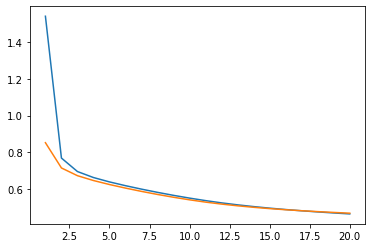

In [ ]:
# Model metrics and performance
epochs_range = [i for i in range(1,epochs+1)]
plt.plot(epochs_range, train_avg_losses)
plt.plot(epochs_range, val_avg_losses)
plt.show()

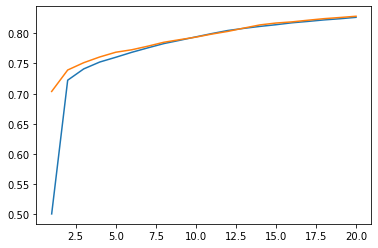

In [ ]:
# Accuracy score

epochs_range = [i for i in range(1,epochs+1)]
plt.plot(epochs_range, train_avg_accuracies)
plt.plot(epochs_range, val_avg_accuracies)
plt.show()

predicted class - actual class: Ankle boot - Ankle boot
predicted class - actual class: Pullover - Pullover
predicted class - actual class: Trousers - Trousers
predicted class - actual class: Trousers - Trousers
predicted class - actual class: Pullover - Shirt


Accuracy: 0.8168


Mean squared Error: 2.2696


Classification report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1000
           1       0.95      0.95      0.95      1000
           2       0.66      0.72      0.69      1000
           3       0.79      0.86      0.82      1000
           4       0.68      0.73      0.70      1000
           5       0.93      0.92      0.93      1000
           6       0.60      0.40      0.48      1000
           7       0.91      0.91      0.91      1000
           8       0.92      0.95      0.93      1000
           9       0.93      0.94      0.94      1000

    accuracy                           0.82     10000
   macro avg    

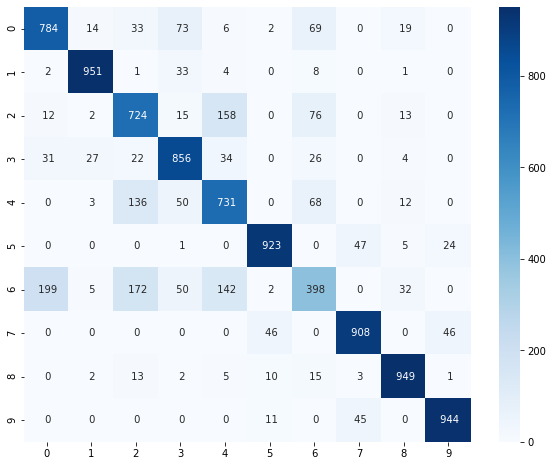

In [ ]:
# Testing with new dataset

(prediction, prediction_classes) = test(model, testing_dataset, classes)

for i in range(5):
    print(f"predicted class - actual class: {prediction_classes[i]} - {classes[testing_data[i][1]]}")


print("\n")


accuracy = accuracy_score(y_test, prediction)
print(f"Accuracy: {accuracy}")


print("\n")


mse = mean_squared_error(y_test, prediction)
print("Mean squared Error:", mse)


print("\n")


report = classification_report(y_test, prediction)
print("Classification report:")
print(report)


print("\n")


confusion = confusion_matrix(y_test, prediction)
print(confusion)


print("\n")

plt.figure(figsize=(10,8))
sns.heatmap(confusion, cmap="Blues", annot=True, fmt=" ")